In [8]:
import pydicom
import os
import numpy as np
from matplotlib import pyplot, cm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
PathDicom = "./meddata/1/data/images/"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(dirName+'/'+filename)
print (len(lstFilesDCM))

686


Use the first of the DICOM files to read in some of the metadata, specifically the image dimensions, the pixel-spacing, and the slice-thickness

In [4]:
# Get ref file
RefDs = pydicom.read_file(lstFilesDCM[0])
# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
# Calculate coordinate axes for this array 
x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

In [6]:
%%time
# Load all the pixel data into an appropriate sized NumPy array named ArrayDicom
# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = pydicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array  

print ('Image shape: ',ArrayDicom.shape)
print ('Image values: ',ArrayDicom.min(),'-',ArrayDicom.max())

Image shape:  (686, 686, 686)
Image values:  0 - 4095
Wall time: 6.37 s


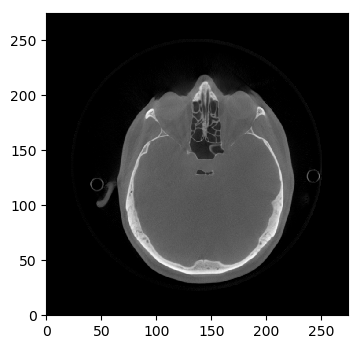

In [11]:
# 3th axis slice
pyplot.figure(dpi=100)
pyplot.axes().set_aspect('equal')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, y, numpy.flipud(ArrayDicom[:, :, 300]));

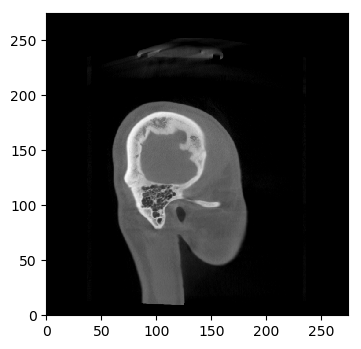

In [13]:
# 2th axis slice
pyplot.figure(dpi=100)
pyplot.axes().set_aspect('equal')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(z, x, numpy.flipud(ArrayDicom[:, 200, :]).T);

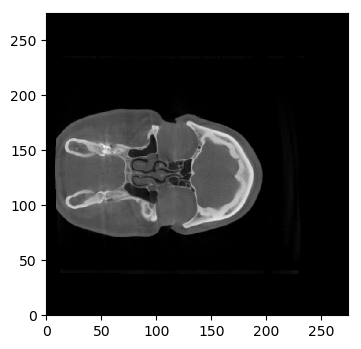

In [20]:
# 1th axis slice
pyplot.figure(dpi=100)
pyplot.axes().set_aspect('equal')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(z, x, numpy.flipud(ArrayDicom[200, :, :]));

### Simple ITK
Loading the series of DICOM files into a single SimpleITK.

Image object, smoothing that image to reduce noise, segmenting the tissues using region-growing techniques, filling holes in the resulting tissue-labels

In [22]:
# # Juypyter Notebook Repository 
# # http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/
    
# # first  https://pyscience.wordpress.com/2014/10/19/image-segmentation-with-python-and-simpleitk/
# # second  https://pyscience.wordpress.com/2014/11/02/multi-modal-image-segmentation-with-python-simpleitk/
# # https://nbviewer.jupyter.org/urls/bitbucket.org/somada141/pyscience/raw/master/20141001_SegmentationSimpleITK/Material/SegmentationSimpleITK.ipynb
      
import os
import numpy
import SimpleITK
import matplotlib.pyplot as plt
%pylab inline

In [21]:
reader = SimpleITK.ImageSeriesReader()
pathDicom = "./meddata/1/data/images/1/"
filenamesDICOM = reader.GetGDCMSeriesFileNames(pathDicom)
reader.SetFileNames(filenamesDICOM)
imgOriginal = reader.Execute()

# Z slice of the DICOM files to process. In the interest of
# simplicity, segmentation will be limited to a single 2D
# image but all processes are entirely applicable to the 3D image
idxSlice = 100

# int labels to assign to the segmented white and gray matter.
# These need to be different integers but their values themselves
# don't matter
labelWhiteMatter = 1
labelGrayMatter = 2

In [17]:
# Function to quickly plot a 2D SimpleITK image with a grayscale colormap
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    print (img.GetSize())
    nda = SimpleITK.GetArrayFromImage(img)
    print (nda.shape)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()
    

# If you were to have a SimpleITK.Image object with a size/shape of 200x100x50, 
# then upon conversion to a numpy.ndarray that object would exhibit a shape of 50x100x200, 
# i.e., the axes would be backwards.    

In [23]:
imgOriginal = imgOriginal[:,:,idxSlice]

(686, 686)
(686, 686)


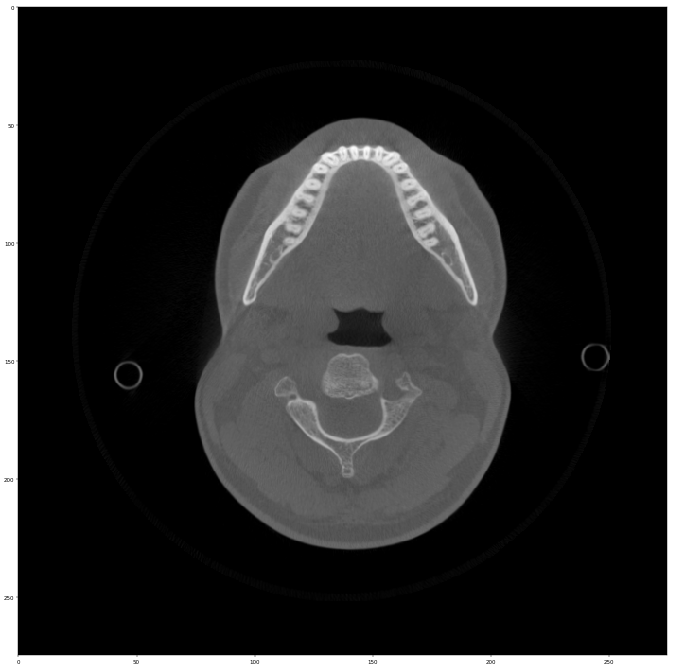

In [32]:
sitk_show(imgOriginal)

### Smoothing
Apply a filter to smoothen the image (get rid of image noise)

(686, 686)
(686, 686)


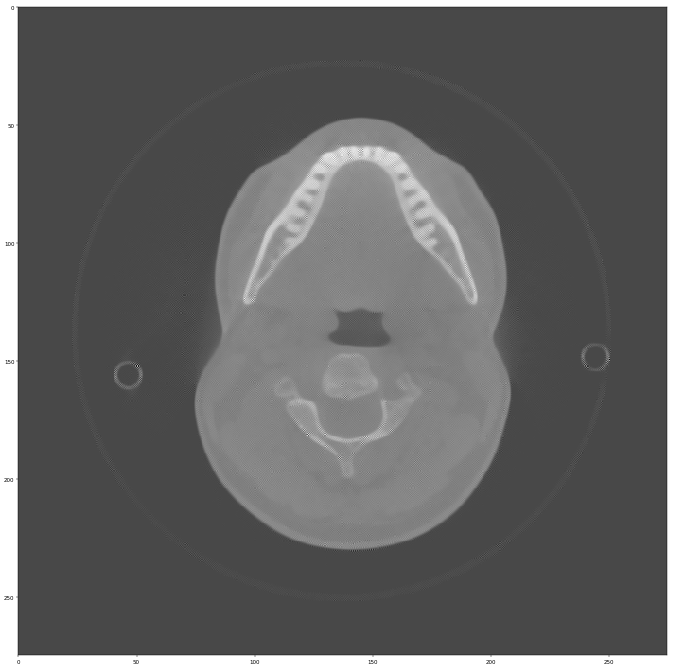

In [38]:
imgSmooth = SimpleITK.CurvatureFlow(image1=imgOriginal,
                                    timeStep=0.125,
                                    numberOfIterations=5)
# blurFilter = SimpleITK.CurvatureFlowImageFilter()
# blurFilter.SetNumberOfIterations(5)
# blurFilter.SetTimeStep(0.125)
# imgSmooth = blurFilter.Execute(imgOriginal)
sitk_show(imgSmooth)

### Segmentation with the ConnectedThreshold 
filter Initial segmentation of white matter

(686, 686)
(686, 686, 3)


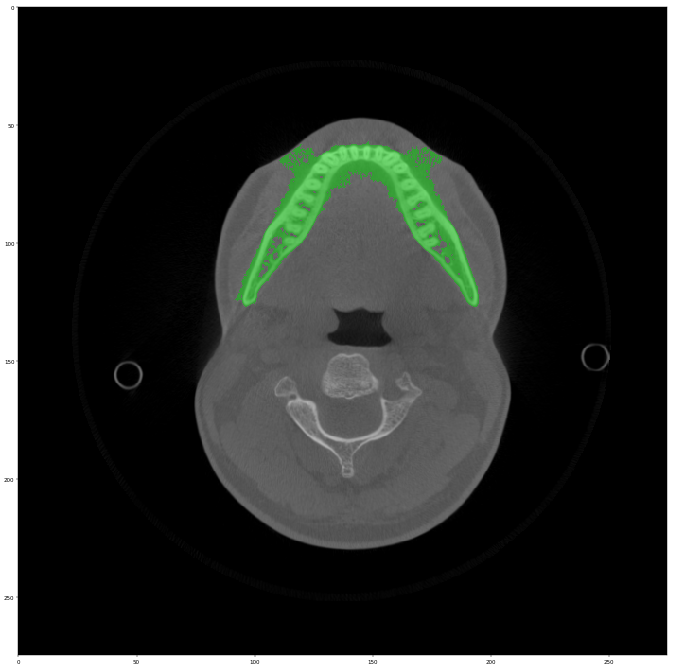

In [25]:
lstSeeds = [(300,160)]

imgWhiteMatter = SimpleITK.ConnectedThreshold(image1=imgOriginal, 
                                              seedList=lstSeeds, 
                                              lower=90, 
                                              upper=4000,
                                              replaceValue=labelWhiteMatter)

# Rescale 'imgSmooth' and cast it to an integer type to match that of 'imgWhiteMatter'
imgOrigInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgOriginal), imgWhiteMatter.GetPixelID())

# Use 'LabelOverlay' to overlay 'imgSmooth' and 'imgWhiteMatter'
sitk_show(SimpleITK.LabelOverlay(imgOrigInt, imgWhiteMatter))